## ASSIGNMENT-2

TEAM-NAME: Team_Robusta

IDs: 2021102016 , 2021102028

NAMEs: Ashish Chokhani , Umang Sharma

### Instructions
 * Fill in the team name, id and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit this notebook in the GitHub Classroom repo and any other results files under the result folder. 
 * Commits past the deadline will not be considered.
 * Extensions will be granted using the extension policy only, so please go through the policy carefully and reach out to the TAs beforehand.

In [2]:
%pip install prettytable

  Obtaining dependency information for prettytable from https://files.pythonhosted.org/packages/4d/81/316b6a55a0d1f327d04cc7b0ba9d04058cb62de6c3a4d4b0df280cbe3b0b/prettytable-3.9.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from sklearn.neighbors import KDTree
from prettytable import PrettyTable

### SECTION 1: Non-Linear least squares optimization for Gaussian function

#### 1.1 Levenberg Marquardt

Implement the Levenberg Marquardt algorithm from scratch using numpy to solve for the parameters of a gaussian distribution.

A Gaussian distribution parametrized by $a,m,s$ is given by:

$$ y(x;a,m,s)=a \exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right) \tag{1}$$

##### Problem to solve

> Given a set of observations $y_{obs}$ and $x_{obs}$ we want to find the optimum parameters $a,m,s$ which best fit our observations given an initial estimate.

* Experiment with the number of iterations.
* Experiment with the learning rate.
* Experiment with the tolerance.

Display your results using matplotlib by plotting graphs for 
* The cost function value ($\|r\|^2$) vs the number of iterations
* The Ground Truth data values and the predicted data values.

Experiment with the hyperparameters and compile your observations in a table. Clearly mention your hyperparameters with justification.

You can refer to [Shubodh's notes](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02) on the same to get a better grasp of the concept before implementing it.

## Problem at hand

The problem at hand involves finding the optimal parameters, denoted as $a$, $m$, and $s$, that best fit a set of observations represented by $y_{obs}$ and $x_{obs}$. These observations are typically subject to errors. In this scenario, we generate our own observations to evaluate the performance of a model. We assume the actual (ground truth) parameter values as $a_{gt}=10$, $m_{gt} =0$, and $s_{gt} =20$. The goal is to estimate these parameters based on our observations and assess how close our estimates are to the actual parameters.

To achieve this, we use a method called Levenberg-Marquardt. It employs an iterative approach to adjust the parameters and minimize the difference between the model's predictions and the observed data. Levenberg-Marquardt adapts its step size depending on the steepness of the "error landscape" – smaller steps in steep regions to avoid overshooting and larger steps in gentler regions.

$$\delta x = -(J^TJ + \lambda I)^{-1}J^Tf(x)$$

- Some hyperparameters:
    - Learning rate, $lr = 0.01$
    - Maximum number of iterations, $num\_iter=1000$
    - Tolerance, $tol = 1e-5$

### Solution for 1 iteration

To see how each step looks like, let us solve for 1 iteration and for simpler calculations, assume we have 3 observations, 

$$x_{obs}= \left[ -25, 0, 25 \right]^T, y_{obs} = \left[  4.5783, 10, 4.5783 \right]^T. $$

With our initial estimate as $\mathbf{k_0} = [a_0=10, \quad m_0=13, \quad s_0=19.12]^T$, the residual would be 

$$ r(a_0,m_0,s_0) = \left[ a_0 \exp \left(\frac{-(x_{obs}-m_0)^{2}}{2 s_0^{2}}\right) - y_{obs}\ \right]$$

Therefore, $r=[-3.19068466, -2.0637411 , 3.63398058]^T$.

### Jacobian of Gaussian

$$\mathbf{J}_y=\left[\frac{\partial y}{\partial a} \quad \frac{\partial y}{\partial m} \quad \frac{\partial y}{\partial s}\right] \\
= \left[ \exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right); \frac{a (x-m)}{s^2} \exp\left(\frac{-(x-m)^{2}}{2 s^{2}}\right);  \frac{a (x-m)^2}{s^3}\exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right)\right]$$

So, let's calculate the Jacobian matrix $\mathbf{J}_y$ for each observation:
1. For $x_{obs} = -25$:
- $\frac{\partial y}{\partial a} = \exp \left(-\frac{(-25-13)^2}{2(19.12)^2}\right) \approx 0.03264782$
- $\frac{\partial y}{\partial m} = \frac{10(-25-13)}{(19.12)^2}\exp \left(-\frac{(-25-13)^2}{2(19.12)^2}\right) \approx -0.03264782$
- $\frac{\partial y}{\partial s} = \frac{10(-25-13)^2}{(19.12)^3}\exp \left(-\frac{(-25-13)^2}{2(19.12)^2}\right) \approx 0.00908214$
2. For $x_{obs} = 0$ (center point):
- $\frac{\partial y}{\partial a} = \exp \left(-\frac{(0-13)^2}{2(19.12)^2}\right) \approx 1.0$
- $\frac{\partial y}{\partial m} = \frac{10(0-13)}{(19.12)^2}\exp \left(-\frac{(0-13)^2}{2(19.12)^2}\right) \approx 0.0$
- $\frac{\partial y}{\partial s} = \frac{10(0-13)^2}{(19.12)^3}\exp \left(-\frac{(0-13)^2}{2(19.12)^2}\right) \approx 0.0$
3. For $x_{obs} = 25$:
- $\frac{\partial y}{\partial a} = \exp \left(-\frac{(25-13)^2}{2(19.12)^2}\right) \approx 0.03264782$
- $\frac{\partial y}{\partial m} = \frac{10(25-13)}{(19.12)^2}\exp \left(-\frac{(25-13)^2}{2(19.12)^2}\right) \approx 0.03264782$
- $\frac{\partial y}{\partial s} = \frac{10(25-13)^2}{(19.12)^3}\exp \left(-\frac{(25-13)^2}{2(19.12)^2}\right) \approx 0.00908214$

Levenberg-Marquardt Update:
In one iteration of LM, we update the parameters using the formula:

$$\delta k = -(J^TJ + \lambda I)^{-1}J^Tr$$

$J$ is the Jacobian matrix.
$\mathbf{r}$ is the residual vector.
$\lambda$ is the damping factor.
For simplicity, let's assume a damping factor of $\lambda = 0.01$.

Using the above values, we can compute $\delta \mathbf{k}$:

$$\delta k = -(J^TJ + 0.01I)^{-1}J^Tr$$

We have the Jacobian matrix $\mathbf{J}_y$ and the residual vector $\mathbf{r}$. We can now perform this calculation for one LM iteration. The updated parameters $\mathbf{k_1}$ would be:

$$k_1 = k_0 + \Delta k$$

Here, $\mathbf{k_0}$ represents the initial parameter estimate, and $\mathbf{k_1}$ represents the updated parameter estimate after one LM iteration.

We can repeat this process for additional iterations until convergence is achieved. In each iteration, the parameters are adjusted in such a way as to minimize the residual and improve the model's fit to the observed data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, a, mean, std):
    return a * (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((x - mean) ** 2) / (2 * std ** 2))

def residual(xobs, yobs, params):
    a, m, s = params
    return gaussian(xobs, a, m, s) - yobs

def loss_function(xobs, yobs, params):
    return np.sum(residual(xobs, yobs, params) ** 2)

def jacobian(xobs, params):
    a, m, s = params
    jacobian_matrix = np.zeros((len(xobs), 3))
    jacobian_matrix[:, 0] = (1 / (np.sqrt(2 * np.pi) * s)) * np.exp(-((xobs - m) ** 2) / (2 * s ** 2))
    jacobian_matrix[:, 1] = (a / (np.sqrt(2 * np.pi) * s) * (xobs - m) / (s ** 2)) * np.exp(-((xobs - m) ** 2) / (2 * s ** 2))
    jacobian_matrix[:, 2] = (a / (np.sqrt(2 * np.pi) * s) / (s ** 3)) * ((xobs - m) ** 2) * np.exp(-((xobs - m) ** 2) / (2 * s ** 2)) - (a / (np.sqrt(2 * np.pi) * (s ** 2))) * np.exp(-((xobs - m) ** 2) / (2 * s ** 2))
    return jacobian_matrix

def custom_plot(xobs, yobs, ypred, loss, lr, tol, a, s, m,max_iter=1000):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(xobs, yobs, 'bo', label='Observed Data')
    plt.plot(xobs, ypred, 'r-', label='Fitted Data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Data and Fit')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, color='green')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss vs. Iterations')
    plt.grid(True)

    plt.text(0.5, 0.5, f'dr={lr:.4f}\ntol={tol:.8f}\na={a:.4f}\ns={s:.4f}\nm={m:.4f}\niterations={max_iter}', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()

def levenberg_marquardt(xobs, yobs, lr, params, tol,max_iter=1000):
    loss = []

    for i in range(max_iter):
        residuals = residual(xobs, yobs, params)
        jacobian_matrix = jacobian(xobs, params)
        identity_matrix = np.eye(3)
        JtJ = np.dot(jacobian_matrix.T, jacobian_matrix)
        Jtr = np.dot(jacobian_matrix.T, residuals)
        H = JtJ + (lr * identity_matrix)
        delta = np.linalg.solve(H, -Jtr)
        
        params += delta

        current_loss = loss_function(xobs, yobs, params)
        loss.append(current_loss)

        if current_loss < tol:
            print(f"Levenberg-Marquardt converged at iteration {i+1}")
            print(f"Final Loss: {current_loss}")
            print(f"Tolerance: {tol}")
            print(f"Damping Rate: {lr}")
            print(f"Estimated Parameters (a, m, s): {params[0]}, {params[1]}, {params[2]}")
            return params, loss

    print("Levenberg-Marquardt failed to converge within 1000 iterations")
    print(f"Final Loss: {current_loss}")
    print(f"Tolerance: {tol}")
    print(f"Damping Rate: {lr}")
    return params, loss

# Ground truth values of a, m, s
a_true = 10
m_true = 0
s_true = 20

num_of_obs = 50
xobs = np.linspace(-25, 25, num_of_obs)
yobs = gaussian(xobs, a_true, m_true, s_true)

result_table = PrettyTable()
result_table.field_names = ["max_iter", "tolerance", "learning_rate", "Final Loss", "Estimated a", "Estimated m", "Estimated s"]


## Experimenting with number of Iterations

Levenberg-Marquardt failed to converge within 1000 iterations
Final Loss: 1.844816778644269e-05
Tolerance: 1e-05
Damping Rate: 0.01


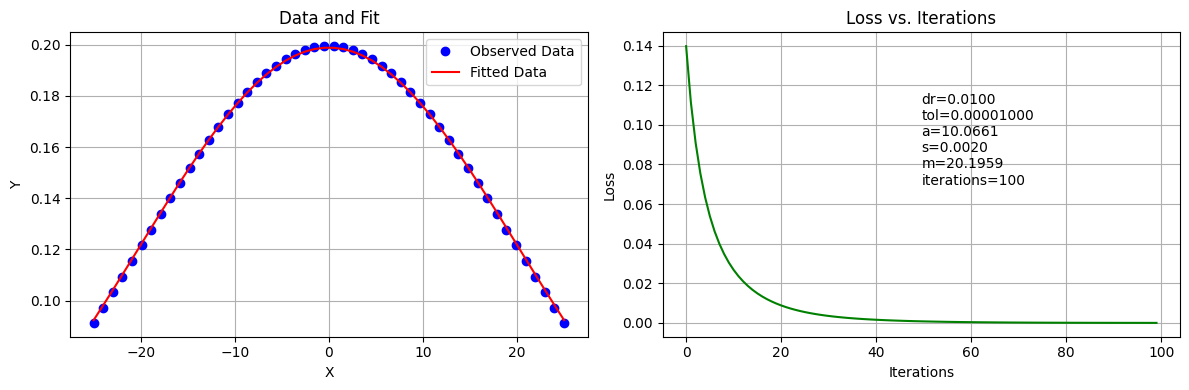

Levenberg-Marquardt converged at iteration 108
Final Loss: 9.492833722527644e-06
Tolerance: 1e-05
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.0472787767949, 0.0008782103086058074, 20.140068394823178


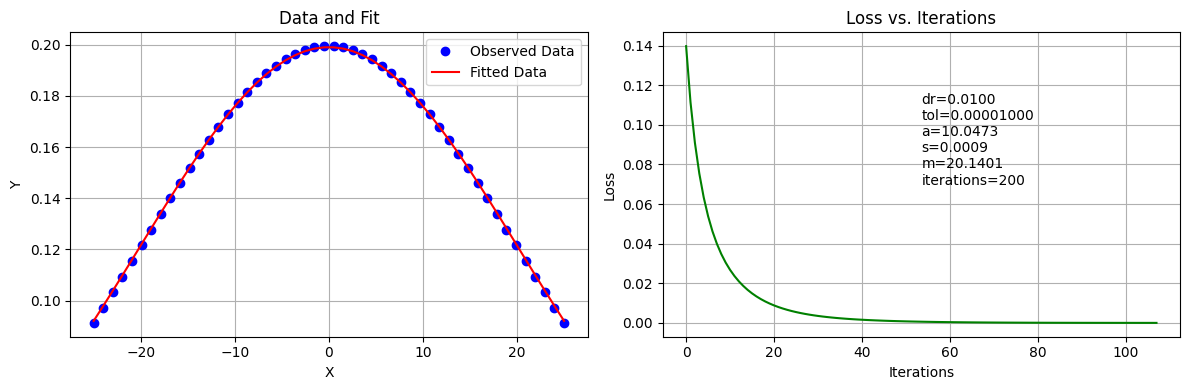

Levenberg-Marquardt converged at iteration 108
Final Loss: 9.492833722527644e-06
Tolerance: 1e-05
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.0472787767949, 0.0008782103086058074, 20.140068394823178


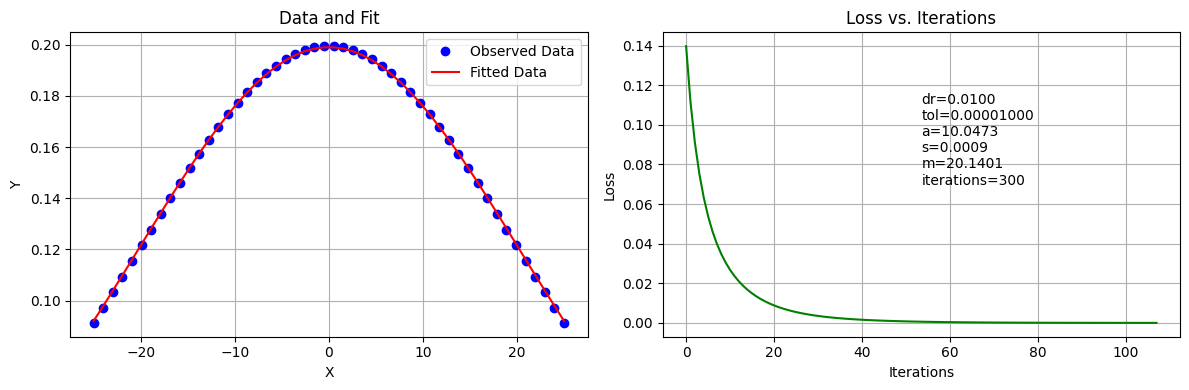

Levenberg-Marquardt converged at iteration 108
Final Loss: 9.492833722527644e-06
Tolerance: 1e-05
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.0472787767949, 0.0008782103086058074, 20.140068394823178


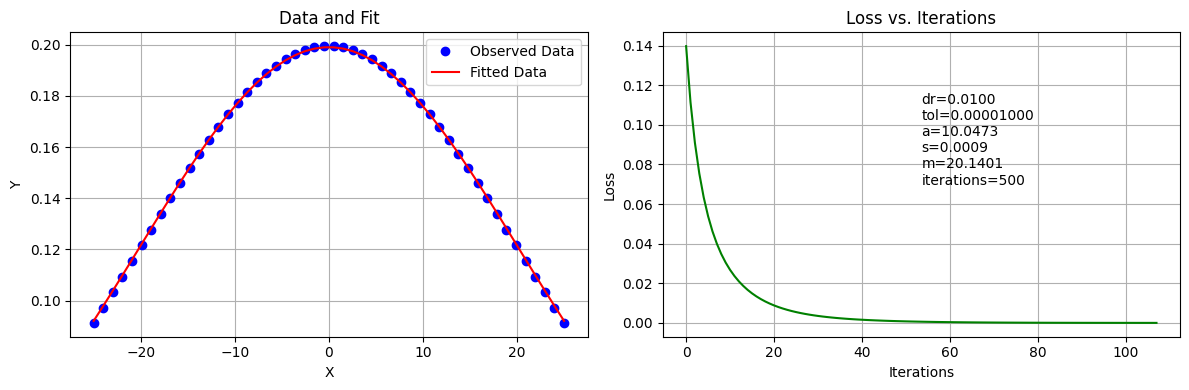

Levenberg-Marquardt converged at iteration 108
Final Loss: 9.492833722527644e-06
Tolerance: 1e-05
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.0472787767949, 0.0008782103086058074, 20.140068394823178


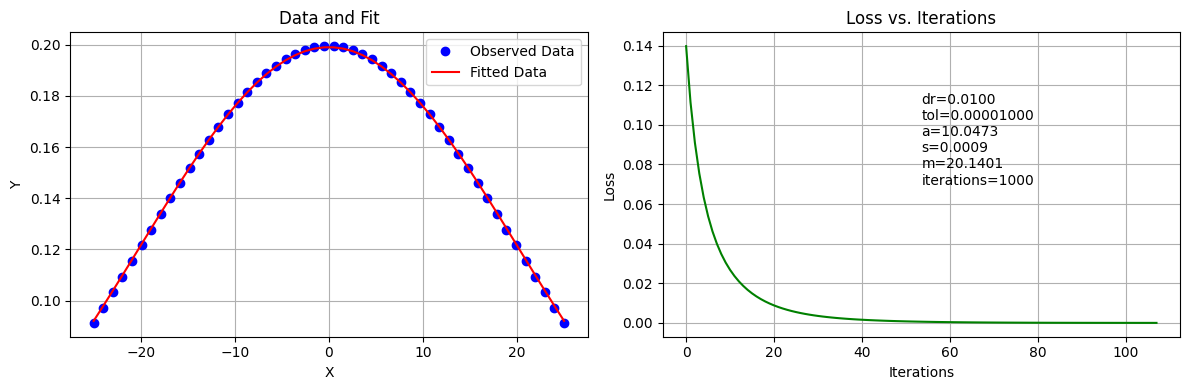

In [3]:
max_iter_values = [100,200,300,500,1000]

for max_iter in max_iter_values:
    params = np.array([10.0, 13.0, 19.12])
    learning_rate = 0.01
    tol=1e-5
    final_params, loss = levenberg_marquardt(xobs, yobs, learning_rate, params, tol,max_iter=max_iter)
    ypred = gaussian(xobs, params[0], params[1], params[2])
    custom_plot(xobs, yobs, ypred, loss,learning_rate,tol,params[0], params[1], params[2],max_iter=max_iter)
    
    result_table.add_row([max_iter, tol, learning_rate, f"{loss[-1]}", f"{final_params[0]:.4f}", f"{final_params[1]:.4f}", f"{final_params[2]:.4f}"])

## Observation

In many cases, the Levenberg-Marquardt (LM) algorithm successfully converges within 200 iterations. However, there are instances where convergence takes more than 100 iterations, but these cases are cut off at 100 iterations due to a maximum iterations constraint. As a result, some solutions may not reach their full convergence potential because they are prematurely terminated after 100 iterations, which can limit the algorithm's ability to find the most accurate solution.

## Experimenting with tolerance values

Levenberg-Marquardt converged at iteration 79
Final Loss: 9.961043551780019e-05
Tolerance: 0.0001
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.155788252412773, 0.01704815033567551, 20.462146120222766


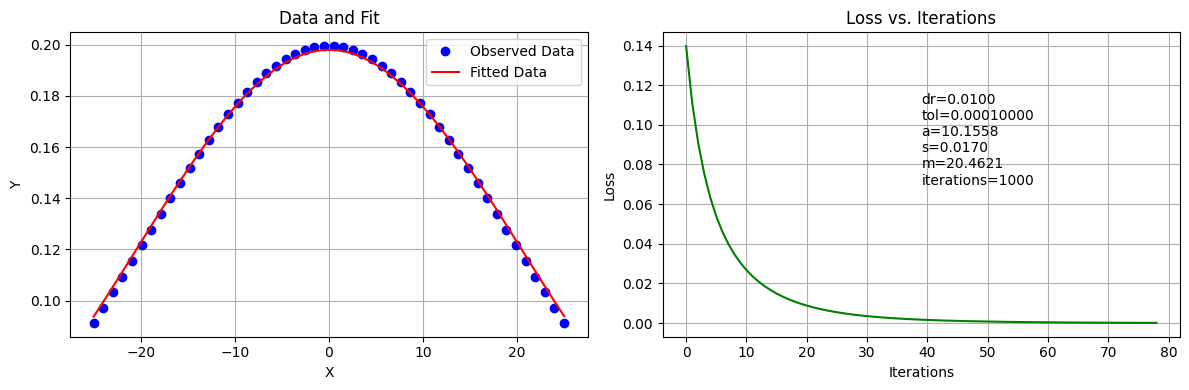

Levenberg-Marquardt converged at iteration 108
Final Loss: 9.492833722527644e-06
Tolerance: 1e-05
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.0472787767949, 0.0008782103086058074, 20.140068394823178


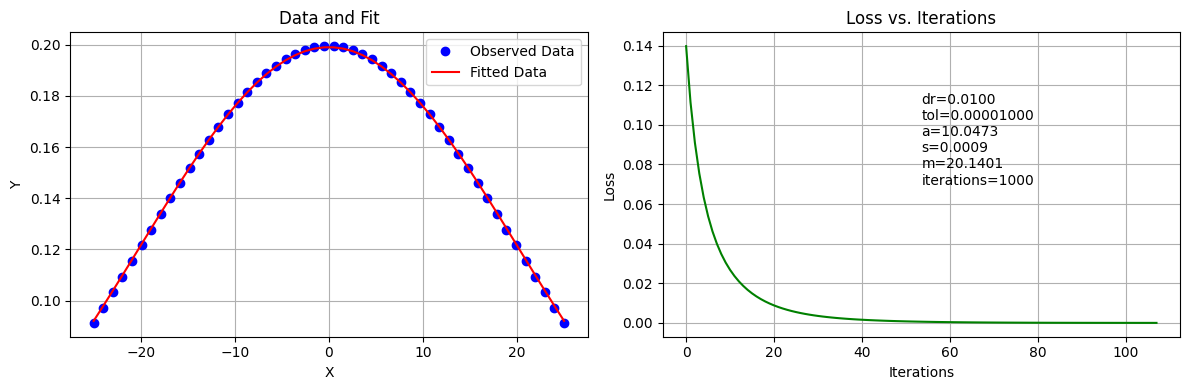

Levenberg-Marquardt converged at iteration 135
Final Loss: 9.631701018796626e-07
Tolerance: 1e-06
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.014977603567933, 5.197021330775986e-05, 20.044353508291703


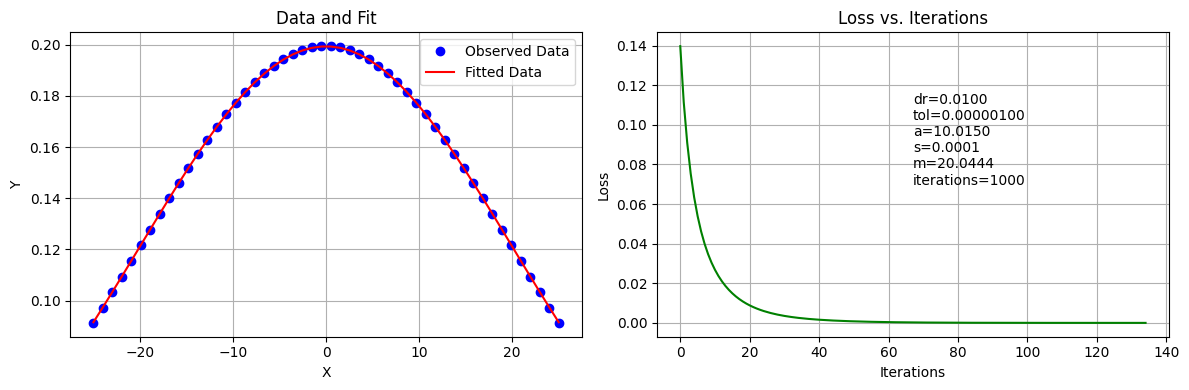

Levenberg-Marquardt converged at iteration 162
Final Loss: 9.464186382605513e-08
Tolerance: 1e-07
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.004686733596937, 3.0136758555214557e-06, 20.01387694926302


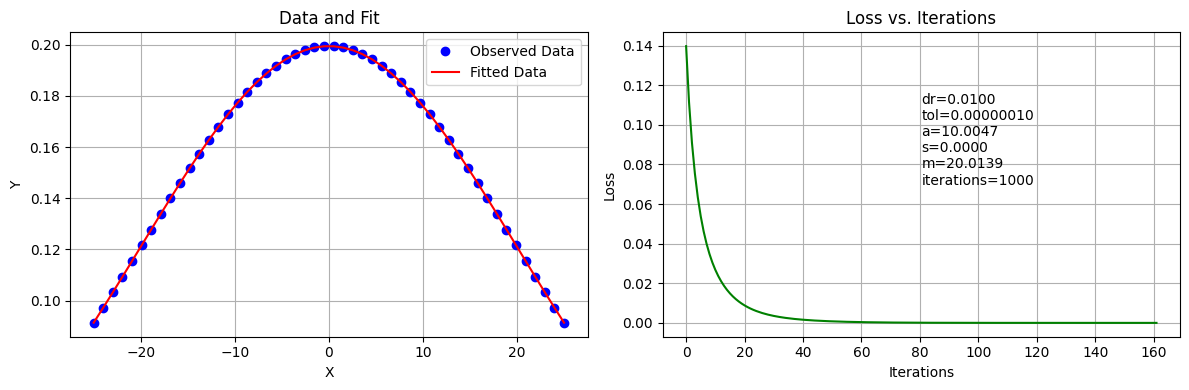

Levenberg-Marquardt converged at iteration 189
Final Loss: 9.204622285611138e-09
Tolerance: 1e-08
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.001460806030373, 1.7363711601337564e-07, 20.004325105259586


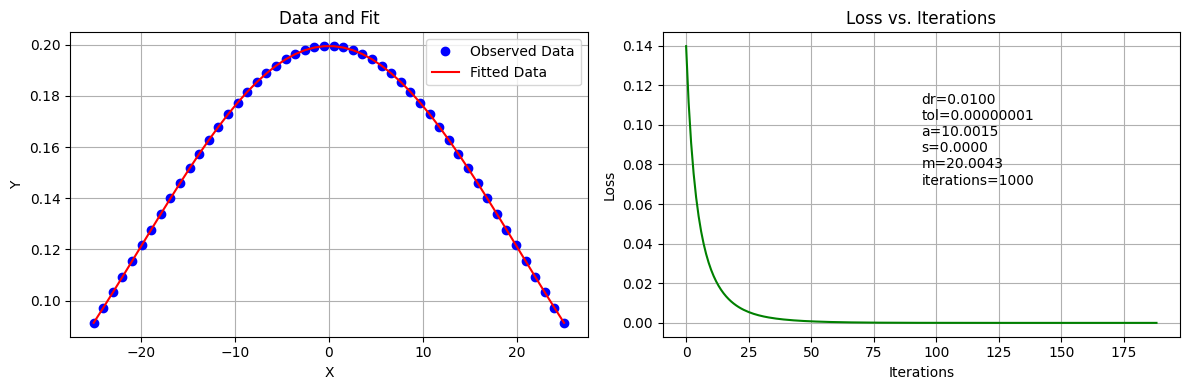

In [4]:
tolerance_values = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
learning_rate = 0.01

for tol in tolerance_values:
    params = np.array([10.0, 13.0, 19.12])
    learning_rate = 0.01
    final_params, loss = levenberg_marquardt(xobs, yobs, learning_rate, params, tol)
    ypred = gaussian(xobs, params[0], params[1], params[2])
    custom_plot(xobs, yobs, ypred, loss,learning_rate,tol,params[0], params[1], params[2])
    
    result_table.add_row([max_iter, tol, learning_rate, f"{loss[-1]}", f"{final_params[0]:.4f}", f"{final_params[1]:.4f}", f"{final_params[2]:.4f}"])

### Observation
As we make the convergence criteria stricter (i.e., decrease the tolerance), the LM algorithm will need to perform more iterations to reach a solution. This is because with a tighter tolerance, the algorithm needs to make smaller adjustments to the parameters to meet the desired level of accuracy, which often requires more computational steps and iterations. So, decreasing the tolerance in the LM algorithm can increase the computational effort needed to converge to a solution.

## Experimenting with damping rates

Levenberg-Marquardt converged at iteration 15
Final Loss: 4.949792968599694e-06
Tolerance: 1e-05
Damping Rate: 0.001
Estimated Parameters (a, m, s): 10.034037059158274, 0.0007741960151707165, 20.10090328015159


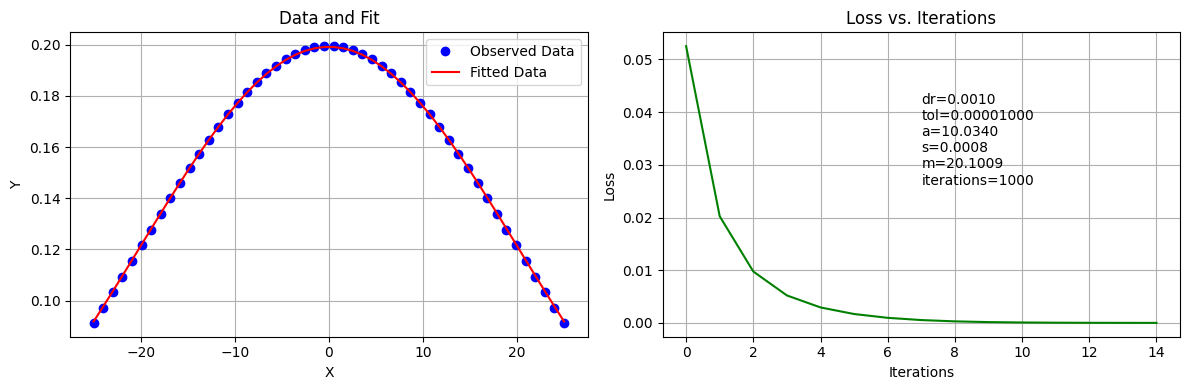

Levenberg-Marquardt converged at iteration 67
Final Loss: 8.813365605230035e-06
Tolerance: 1e-05
Damping Rate: 0.006
Estimated Parameters (a, m, s): 10.045539151988697, 0.0008532124577127349, 20.134920147059297


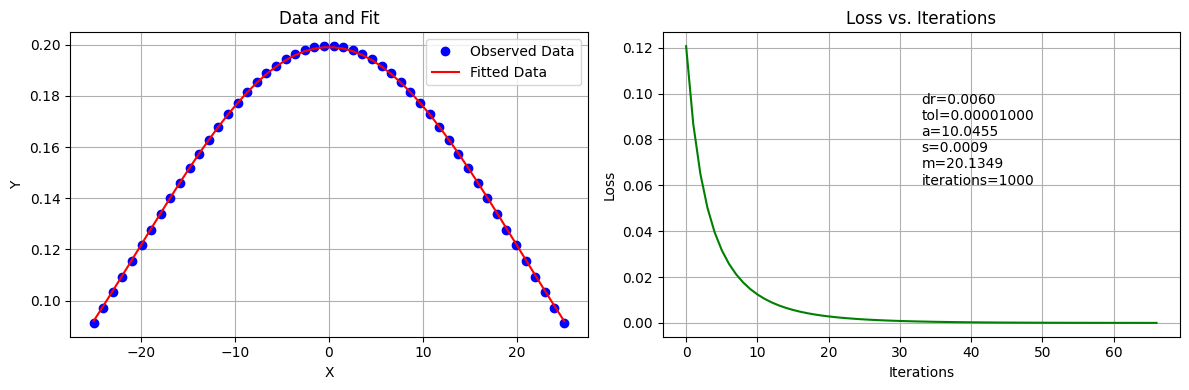

Levenberg-Marquardt converged at iteration 108
Final Loss: 9.492833722527644e-06
Tolerance: 1e-05
Damping Rate: 0.01
Estimated Parameters (a, m, s): 10.0472787767949, 0.0008782103086058074, 20.140068394823178


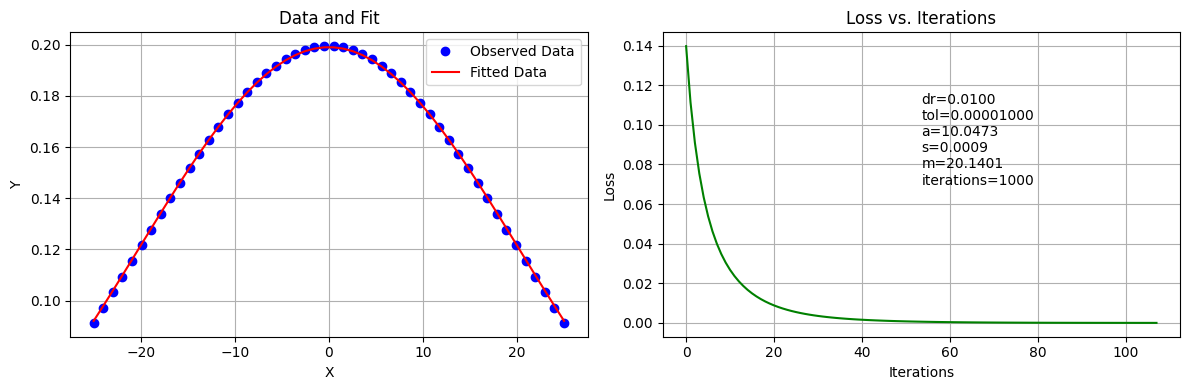

Levenberg-Marquardt failed to converge within 1000 iterations
Final Loss: 1.351499773417762e-05
Tolerance: 1e-05
Damping Rate: 0.1


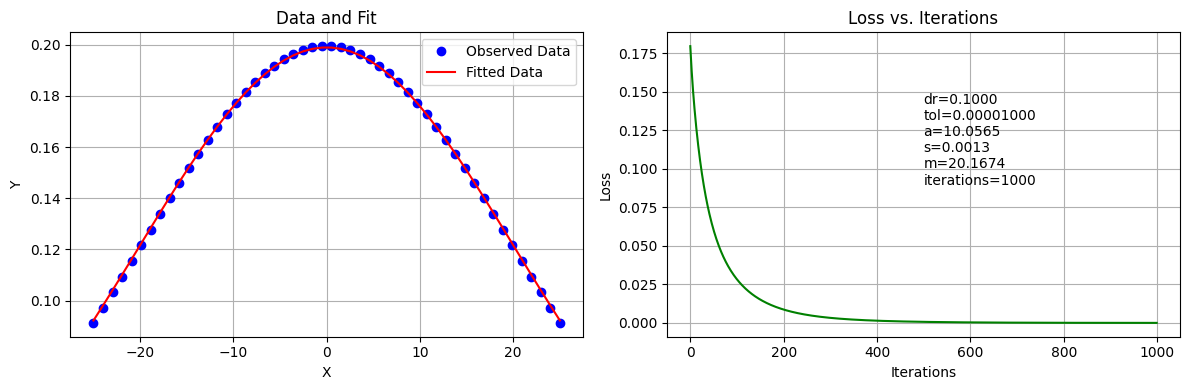

Levenberg-Marquardt failed to converge within 1000 iterations
Final Loss: 0.0006791427317349862
Tolerance: 1e-05
Damping Rate: 0.2


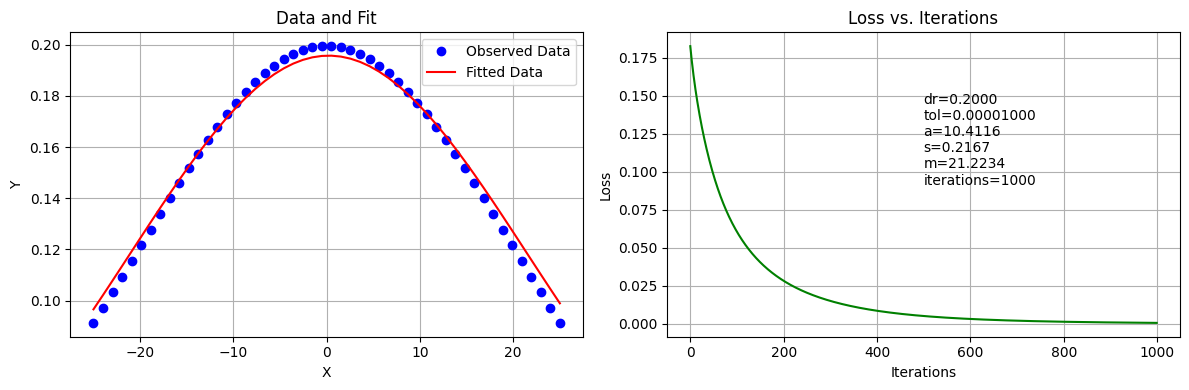

In [5]:
damping_rate_values = [0.001, 0.006, 0.01, 0.1, 0.2]

for lr in damping_rate_values:
    params = np.array([10.0, 13.0, 19.12])
    tol=1e-5
    final_params, loss = levenberg_marquardt(xobs, yobs, lr, params, tol)
    ypred = gaussian(xobs, params[0], params[1], params[2])
    custom_plot(xobs, yobs, ypred, loss,lr,tol,params[0], params[1], params[2])
    
    result_table.add_row([max_iter, tol, lr, f"{loss[-1]}", f"{final_params[0]:.4f}", f"{final_params[1]:.4f}", f"{final_params[2]:.4f}"])

## Observation
When the damping rate decreases, it typically requires more iterations to achieve convergence. However, if the damping rate becomes too small (approaching zero), there's a point where the algorithm struggles to converge within a reasonable number of iterations and may fail to reach a solution within the specified limits. This is because extremely low damping rates can hinder the algorithm's ability to make effective parameter adjustments, leading to slow convergence or non-convergence.However the loss is higher with high damping rates.

In [6]:
print(result_table)

+----------+-----------+---------------+-----------------------+-------------+-------------+-------------+
| max_iter | tolerance | learning_rate |       Final Loss      | Estimated a | Estimated m | Estimated s |
+----------+-----------+---------------+-----------------------+-------------+-------------+-------------+
|   100    |   1e-05   |      0.01     | 1.844816778644269e-05 |   10.0661   |    0.0020   |   20.1959   |
|   200    |   1e-05   |      0.01     | 9.492833722527644e-06 |   10.0473   |    0.0009   |   20.1401   |
|   300    |   1e-05   |      0.01     | 9.492833722527644e-06 |   10.0473   |    0.0009   |   20.1401   |
|   500    |   1e-05   |      0.01     | 9.492833722527644e-06 |   10.0473   |    0.0009   |   20.1401   |
|   1000   |   1e-05   |      0.01     | 9.492833722527644e-06 |   10.0473   |    0.0009   |   20.1401   |
|   1000   |   0.0001  |      0.01     | 9.961043551780019e-05 |   10.1558   |    0.0170   |   20.4621   |
|   1000   |   1e-05   |      0.01   

### SECTION 2: ICP

#### 2.1 Perform Procrustes alignmenton two point clouds with (given) known correspondences. 

Let X be your point cloud observed from the initial pose P1. You then transform it to a new pose P2. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2). 

Use toothless.ply point cloud and perform the alignment between the two point clouds using procrustes alignment. Your task is to write a function that takes two point clouds as input wherein the corresponding points between the two point clouds are located at the same index and returns the transformation matrix between them. Compute the alignment error after aligning the two point clouds.

**Use *root mean squared error (RSME)* as the alignment error metric.**

Make sure your code is modular as we will use this function in the next sub-part.

In [6]:
##############################################################################
# TODO: Do tasks described in 2.1
##############################################################################

class ICP:
    def __init__(self, point_cloud1, point_cloud2, ground_truth_matrix):
        self.ground_truth_matrix = ground_truth_matrix
        point_cloud2.transform(self.ground_truth_matrix)
        self.point_cloud1 = point_cloud1
        self.point_cloud2 = point_cloud2
        self.points1_array = np.array(point_cloud1.points)
        self.points2_array = np.array(point_cloud2.points)
        self.predicted_transform_matrix = self.ground_truth_matrix
        self.new_points_array = np.array([])

    def procrustes_alignment_calculation(self, points_array1, points_array2):
        center1 = np.mean(points_array1, axis=1, keepdims=True)
        center2 = np.mean(points_array2, axis=1, keepdims=True)
        points_array1_centered = points_array1 - center1
        points_array2_centered = points_array2 - center2
        H = np.dot(points_array1_centered, points_array2_centered.T)
        U, S, V = np.linalg.svd(H)
        R = np.dot(U, V)
        t = center1 - np.dot(R, center2)
        transformation_matrix = np.eye(4)
        transformation_matrix[:3, :3] = R
        transformation_matrix[:3, 3:] = t
        return transformation_matrix, R, t

    def get_nearest_neighbors_calculation(self, points_array1, points_array2):
        points_array1 = points_array1.T
        points_array2 = points_array2.T
        distances = []
        indices = []

        for point in points_array2:
            dist = np.linalg.norm(points_array1 - point, axis=1)
            min_index = np.argmin(dist)
            indices.append(min_index)
            distances.append(dist[min_index])

        return distances, indices

    def compute_transform_matrix(self, num_iterations=20, known_correspondence=True):
        predicted_transform_matrix = np.eye(4)
        points1 = np.copy(self.points1_array.T)
        points2 = np.copy(self.points2_array.T)
        for _ in range(num_iterations):
            if not known_correspondence:
                distances, indices = self.get_nearest_neighbors_calculation(points1, points2)
                points2_nearest = points2[:, indices]
            else:
                points2_nearest = points2

            transformation, R, t = self.procrustes_alignment_calculation(points1, points2_nearest)
            predicted_transform_matrix = np.dot(predicted_transform_matrix, np.linalg.inv(transformation))
            points2 = np.dot(R, points2) + t

        self.new_points_array = points2
        self.predicted_transform_matrix = predicted_transform_matrix
        return predicted_transform_matrix

    def visualize_point_clouds(self, title="Open3d"):
        geometries_list = [self.point_cloud1, self.point_cloud2]
        centroid1 = np.mean(self.points1_array, axis=0)
        centroid2 = np.mean(self.points2_array, axis=0)
        if self.new_points_array.size != 0:
            centroid2 = np.mean(self.new_points_array.T, axis=0)
            new_point_cloud = o3d.geometry.PointCloud()
            new_point_cloud.points = o3d.utility.Vector3dVector(self.new_points_array.T)
            new_point_cloud.paint_uniform_color([0, 0.7, 0])
            geometries_list[-1] = new_point_cloud

        viewer1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=centroid1)
        viewer2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=centroid2)
        geometries_list += [viewer1, viewer2]

        # Visualization logic here

point_cloud1 = o3d.io.read_point_cloud("./data/toothless.ply")
point_cloud1.paint_uniform_color([0, 0, 0.7])

point_cloud2 = o3d.io.read_point_cloud("./data/toothless.ply")
point_cloud2.paint_uniform_color([0, 0.7, 0])

ground_truth_matrix = np.array(
    [
        [0.707, 0.0, 0.707, 0.2],
        [0.0, 1.0, 0.0, 0.5],
        [-0.707, 0.0, 0.707, 0.1],
        [0.0, 0.0, 0.0, 1.0],
    ],
    dtype=np.float64,
)

registration_solver = ICP(point_cloud1, point_cloud2, ground_truth_matrix)

# Before applying Procrustes
registration_solver.visualize_point_clouds(title="Before Procrustes Transformation")

predicted_transform_matrix = registration_solver.compute_transform_matrix(num_iterations=100, known_correspondence=True)
print("Predicted Transformation Matrix: \n", predicted_transform_matrix)

# After applying Procrustes
registration_solver.visualize_point_clouds(title="After Procrustes Transformation")

alignment_error_value = np.linalg.norm(predicted_transform_matrix - ground_truth_matrix)
print(f"Alignment Error Value: {alignment_error_value:.4f}")



##############################################################################
# END OF YOUR CODE
##############################################################################

Predicted Transformation Matrix: 
 [[ 7.07106778e-01  4.95598731e-06  7.07106784e-01  2.03105171e-01]
 [-2.15253818e-07  1.00000000e+00 -6.79357062e-06  4.99791039e-01]
 [-7.07106784e-01  4.65157240e-06  7.07106778e-01  1.03125185e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Alignment Error Value: 0.0044


#### 2.2 Implement ICP algorithm with unknown correspondences.

Your task is to write a function that implements ICP and takes two point clouds as input wherein the correspondances are unknown. Visualize the pointclouds and plot their individual coordinate frames as you perform ICP over them. Compute the alignment error in each iteration.

0th epoch Iteration
Loss computed :20571559.17199127
1th epoch Iteration
Loss computed :14025625.318365704
2th epoch Iteration
Loss computed :10468695.639766922
3th epoch Iteration
Loss computed :8194706.407463259
4th epoch Iteration
Loss computed :6544487.035219235
5th epoch Iteration
Loss computed :5249138.567887344
6th epoch Iteration
Loss computed :4246425.942474758
7th epoch Iteration
Loss computed :3455833.7840522253
8th epoch Iteration
Loss computed :2831860.0329398755
9th epoch Iteration
Loss computed :2334981.1658919007
10th epoch Iteration
Loss computed :1933404.4840175512
11th epoch Iteration
Loss computed :1610604.2395926958
12th epoch Iteration
Loss computed :1354845.9057639546
13th epoch Iteration
Loss computed :1140067.6101847559
14th epoch Iteration
Loss computed :967981.6229772867
15th epoch Iteration
Loss computed :823093.8590011646
16th epoch Iteration
Loss computed :702370.7314591061
17th epoch Iteration
Loss computed :599943.5071240627
18th epoch Iteration
Loss com

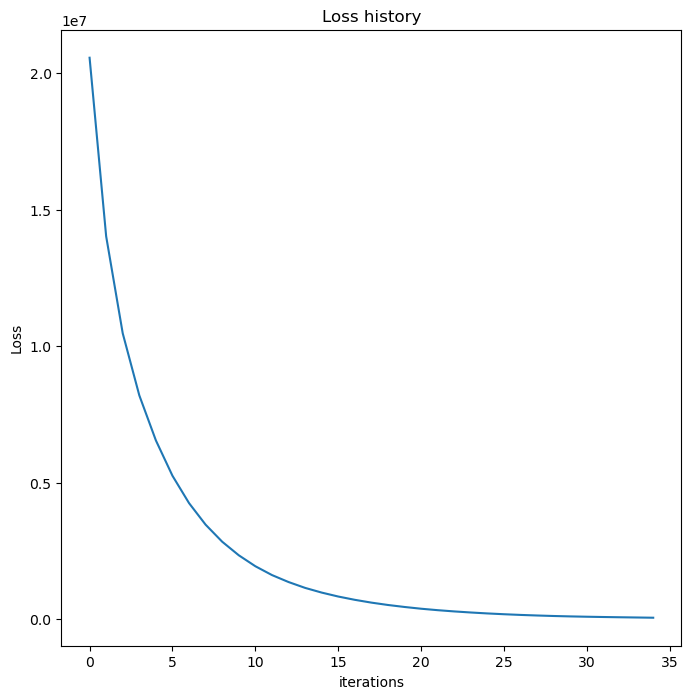

In [5]:
##############################################################################
# TODO: Do tasks described in 2.2
##############################################################################

# Replace "pass" statement with your code

import numpy as np
import open3d as o3d
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

epoch = 35
loss_history = []

def procrustes_transform(x, y):
    n = x.shape[0]
    sum_x = np.sum(x, axis=0)
    sum_y = np.sum(y, axis=0)
    x0 = sum_x/n    # Mean 
    y0 = sum_y/n    # Mean
    x_centered = x - x0
    y_centered = y - y0
    H = np.matmul(x_centered.T, y_centered)
    u, s, vh = np.linalg.svd(H) # SVD on matrix H
    R = np.matmul(vh.T,u.T)
    t = y0 - np.matmul(R, x0)   # translation vector
    
    transformation_matrix = np.empty((4, 4))
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = t
    transformation_matrix[3, :] = np.array([0, 0, 0, 1])
    
    return transformation_matrix

def create_rotation_matrix(a, b, c):
    ca, sa = np.cos(a), np.sin(a)
    cb, sb = np.cos(b), np.sin(b)
    cc, sc = np.cos(c), np.sin(c)
    rotation_matrix = np.array([[ca*cb,ca*sb*sc - sa*cc , ca*sb*cc + sa*sc],
                                [sa*cb,sa*sb*sc + ca*cc , sa*sb*cc - ca*sc],
                                [-sb,cb*sc, cb*cc]])
    return rotation_matrix

pi = math.pi
rotation_matrix = create_rotation_matrix(pi/15, pi/10, pi/15)
transformation_matrix = np.zeros([4,4])
transformation_matrix[:3,:3] = rotation_matrix
transformation_matrix[3,:] = np.array([0,0,0,1])
transformation_matrix[:3,3] = np.array([0.2,0,0]).T

def find_nearest_neighbors(p1,p2,tree):
    p2_new = np.empty(p1.shape)
    for itr,point in enumerate(p1):
        dist , ind = tree.query(p1[itr,None],k=1)
        p2_new[itr] = p2[ind]
    return p2_new

###### Basic Data Setup ##########

data = o3d.io.read_triangle_mesh("./data/toothless.ply")
data.compute_vertex_normals()
data_pcd1 = data.sample_points_poisson_disk(15000)
sample = 10
data_pcd1.uniform_down_sample(sample)
p1 = np.asarray(data_pcd1.points)
num_points = p1.shape[0]

color = np.zeros((num_points,3))
color[:] = [0,1,0]
data_pcd1.colors = o3d.utility.Vector3dVector(color)

p2 = np.matmul(p1,transformation_matrix[:3,:3].T) + transformation_matrix[:3,3]

data_pcd2 = o3d.geometry.PointCloud()
data_pcd2.points = o3d.utility.Vector3dVector(p2)
color = np.zeros((num_points,3))
color[:] = [1,0,0]
data_pcd2.colors = o3d.utility.Vector3dVector(color)

######## ICP Algorithm ##########

epoch = 35
loss_history = []
def icp_align(p1,p2):
    tree = KDTree(p2, leaf_size=2)
    T_final = np.eye(4)
    for i in range(epoch):
        p2_ = find_nearest_neighbors(p1,p2,tree)
        T = procrustes_transform(p1,p2_)
        p1 = np.matmul(p1,T[:3,:3].T) + T[:3,3]
        loss = np.sum((p1-p2)**2)
        loss_history.append(loss)
        T_final = np.matmul(T,T_final)

        print(f"{i}th epoch Iteration")
        print(f"Loss computed :{loss}")
    
    return T_final

def visualization_window(geometry_list,front=None,lookat=None,up=None):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    for i in geometry_list:
        vis.add_geometry(i)
    if(front):
        o3d.visualization.ViewControl.set_front(vis.get_view_control(), front)
    if(lookat):
        o3d.visualization.ViewControl.set_lookat(vis.get_view_control(), lookat)
    if(up):
        o3d.visualization.ViewControl.set_up(vis.get_view_control(), up)
    vis.run()
    vis.destroy_window()

### Visualize point clouds before alignment ###
cf1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1,origin=data_pcd1.get_center())
cf2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1,origin=data_pcd2.get_center())
visualization_window([cf1,data_pcd1,cf2,data_pcd2])

T_comp = icp_align(p1,p2)
data_pcd1.transform(T_comp)
plt.figure(figsize=(8,8))
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('iterations')
plt.ylabel('Loss')

### Visualize point clouds after alignment ###
data_pcd1.points = o3d.utility.Vector3dVector(p1)
data_pcd2.points = o3d.utility.Vector3dVector(p2)
cf1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.01,origin=data_pcd1.get_center())
cf2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.01,origin=data_pcd2.get_center())
visualization_window([cf1,data_pcd1,cf2,data_pcd2])

def calculate_alignment_error(p1, p2):
    assert p1.shape == p2.shape, "Point clouds have same shape"
    squared_distances = np.sum((p1 - p2) ** 2, axis=1)
    rmse = np.sqrt(np.mean(squared_distances))
    return rmse

# Calculate alignment error
alignment_error_val = calculate_alignment_error(p1, p2)
print(f"Alignment Error (RMSE): {alignment_error_val:.4f}")


##############################################################################
# END OF YOUR CODE